In [1]:
#Load Modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import io
import requests
import pycountry
import math
import tensorflow as tf
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import HuberRegressor 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# import warnings#disable warnings
# warnings.filterwarnings('ignore')
NCountries = 0

C:\Users\Arik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Arik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Arik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Arik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

In [2]:
def CreatePlots(df,key,tit, isLog=True, isReturn=False,x0=0,axes=None):
    #Create plots of a specified key, a logarithmic plot is possible
    v = df[key].values[0]
    if isLog:#plot linear and logarithmic scales
        if axes is None:
            fig,axes = plt.subplots(2,1)
        axes[1].plot(v[x0:],marker='.',label=key)
        axes[1].set_title(tit+'-lograithmic')
        axes[1].set_yscale('log')
        axes[0].plot(v[x0:], marker='.',label=key)
        axes[0].set_title(tit+'-linear')
        if "fig" in locals():
            fig.subplots_adjust(hspace=0.4)#set space between plots
    else:#plot only linear scale
        if axes is None:
            axes,fig = plt.subplots(1,1)
        plt.plot(v[x0:], marker='.',label=key)
        plt.title(tit+'-linear')
    if isReturn:
        return axes

In [3]:
def AddMarksToPlot(axes,x,y,tit):
    #add markers at specified points
    if isinstance(axes,np.ndarray):
        for ax in axes:
            ax.scatter(x,y,color='r',zorder=0)
            for xi,yi in zip(x,y):
                ax.annotate(tit,(xi,yi))
    else:
        axes.scatter(x,y,marker='.',color='r',zorder=0)
        for xi,yi in zip(x,y):
                ax.annotate(tit,(xi,yi))

In [4]:
def FindExtrema(df,d1key,tol,lim=5,DoubleCheck=True,CheckLim=3):
    #find zeros of given derivative, classify into maxima and minima, and return indinces
    d1val = np.array(df[d1key].values.tolist())#first derivative
    indEx = abs(d1val) <= tol#indices of points around 0, within tolerance
    #find points where tbhe sign changes
    SignVec = np.diff(np.sign(d1val)).ravel()
    zero_crossingsMin = np.squeeze(np.array(np.where(SignVec>0)))
    zero_crossingsMax = np.squeeze(np.array(np.where(SignVec<0)))
    d2 = np.insert(np.squeeze(np.diff(d1val)),0,0)#second derivative
    #define two vectors representing indices in the data, initialized to false. Once we find extrema, the corresponding
    #index will be set to true
    print(zero_crossingsMin)
    indMin = np.zeros(d1val.shape[1],dtype=bool)
    indMax = np.zeros(d1val.shape[1],dtype=bool)
    indMax[zero_crossingsMax] = True
    indMin[zero_crossingsMin] = True
    #consider both change of sign and second derivative
    indMax = np.logical_and(indMax,abs(d2)>tol) 
    indMin = np.logical_and(indMin,abs(d2)>tol) 
#     if DoubleCheck:
#         l = d1val.shape[1]
#         indMin = DoubleCheckExtrema(SignVec, indMin, zero_crossingMin, l, CheckLim, 1)
#         indMax = DoubleCheckExtrema(SignVec, indMax, zero_crossingMax, l, CheckLim, 0)
    #to avoid edge effects from initial noisy data, set all initial indices(within lim) to False
    indMin[0:lim] = False
    indMax[0:lim] = False
    return indMax,indMin

In [5]:
def AddExtremaToPlot(df,ax,key,d1Key,tol,MaxTit='maximum',MinTit='minimum'):
    #Add markers oon specific points, with the given title (used for extrema and inflection points)
    indMax,indMin = FindExtrema(df,d1Key,tol)
    v = np.squeeze(np.array(df[key].values.tolist()))
    s = max(v.shape) - max(indMax.shape)
    temp = np.zeros(round(s/2),dtype=bool)
    indMax = np.concatenate((temp,indMax,temp))#Pad the indices with False from both sides
    #indMax = np.concatenate(([False],indMax,[False]))
    AddMarksToPlot(ax,np.argwhere(indMax),v[indMax],MaxTit)
    #indMin = np.concatenate(([False],indMin,[False]))
    indMin = np.concatenate((temp,indMin,temp))
    AddMarksToPlot(ax,np.argwhere(indMin),v[indMin],MinTit)

In [6]:
def rolling_window(a, window):
    #rolling window to smooth the data
    a = np.array(a)
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [7]:
def DoubleCheckExtrema(SignDerivative, SignInd, ExInd, length, CheckLim, isMin):
    for ind in ExInd:
        RightInd = ind + CheckLim
        if ind + CheckLim > length:
            RightInd = length + 1
        LeftInd = Ind - CheckLim
        if ind - CheckLim < 0:
            LeftInd = 0
        if not (isMin*SignDerivative[ind+1:ind+CheckLim]>0 and isMin*SignDerivative[ind - CheckLim:ind]<0):
            SignInd[ind] = False
    return ExInd

In [8]:
def manager(df,tit,KeyList,isOrganize = True, isSum=True, isPlot=True):
    #Manages the organisation and reading of the data recieved from the repository
    if isOrganize:
        df = OrganizeDf(df, KeyList)
    if isSum:
        tot = pd.DataFrame(df.cases.tolist()).sum(0)
        df.loc[len(df.index)] = ['worldwide','worldwide',tot.values]
    if isPlot:
        CreatePlots(df[df['Country/Region']=='worldwide'], 'cases', tit)
    df = deriveatives(df, tit, isPlot)
    return df

In [9]:
def deriveatives(df, tit, isPlot = True, key='cases',prefix=''):
    #Calculate first and second derivative and insert them into the dataframe with a specified prefix
    #v = np.array(df['cases'].values)
    #ind = df[key].isin([])
    cur_df = df[~df[key].isna()]# & ind]
    v = np.array(df[key].values.tolist())
    d1 = (v[:,2:] - v[:,0:-2])/2
    d2 = (v[:,2:] - 2*v[:,1:-1] + v[:,0:-2])
    d1str = prefix+'first_derivative'
    d2str = prefix+'second_derivative'
    df[d1str] = d1.tolist()
    df[d2str] = d2.tolist()
    if isPlot:
        CreatePlots(df[df['Country/Region']=='worldwide'], d1str, tit+'1st derivative',isLog=False)
        CreatePlots(df[df['Country/Region']=='worldwide'], d2str, tit+'2nd derivative',isLog=False)
    return df

In [10]:
def ewma_vectorized(data, alpha, offset=None, dtype=None, order='C', out=None):
    """
    Calculates the exponential moving average over a vector.
    Will fail for large inputs.
    :param data: Input data
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param offset: optional
        The offset for the moving average, scalar. Defaults to data[0].
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the input. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if data.ndim > 1:
        # flatten input
        data = data.reshape(-1, order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if offset is None:
        offset = data[0]

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # scaling_factors -> 0 as len(data) gets large
    # this leads to divide-by-zeros below
    scaling_factors = np.power(1. - alpha, np.arange(data.size + 1, dtype=dtype),
                               dtype=dtype)
    # create cumulative sum array
    np.multiply(data, (alpha * scaling_factors[-2]) / scaling_factors[:-1],
                dtype=dtype, out=out)
    np.cumsum(out, dtype=dtype, out=out)

    # cumsums / scaling
    out /= scaling_factors[-2::-1]

    if offset != 0:
        offset = np.array(offset, copy=False).astype(dtype, copy=False)
        # add offsets
        out += offset * scaling_factors[1:]

    return out

In [11]:
def OrganizeDf(df, KeyList):
    #This function organizes the Dataframe, so that the dates won't be column names, 
    #and each row will be a country caontaining a vector of cases every day
    v = df[KeyList[4:]].values
    #if (v.shape[0] < NCountries - 1):
    #    temp = np.zeros((NCountries - v.shape[0],v.shape[1]))
    #    np.concatenate((v,temp),axis=0)
    #ind = df["Country/Region"].str.index("Kosovo")
    #print(v[ind,:])
    df['cases'] = v.tolist()
    df = df.drop(KeyList[4:],axis = 1)
    df = df.drop(['Lat','Long'], axis = 1)
    return df

In [12]:
def ShowData(df_current,key,d1key='',d2key='',tol1=np.inf,tol2=np.inf,isPlot1d=False,isPlot2d=False,tit='',
             isLog=True,AddValToGraph=False,AddValKey='', ax=None, ReturnAxes=False):
    #plot data, add markers, and plot derivatives if desired
    #in order to not display extremum markers, set tol1 or tol2 to infinity
    if tit=='':
        tit = key
    ax = CreatePlots(df_current, key, tit,isReturn=True,axes=ax,isLog=isLog)
    if d1key:
        AddExtremaToPlot(df_current,ax,key,d1key,tol1)#plot 1st derivative
    if d2key:
        AddExtremaToPlot(df_current,ax,key,d2key,tol2,MaxTit='inflection',MinTit='inflection')#plot 2nd derivative
    if AddValToGraph:
        val = df_current[AddValKey].values
        v=np.array([val[0]]*2)#np.ones(np.shape(df_current[key].values))*val[0]
        if isinstance(ax,np.ndarray):
            for a in ax:
                x = a.get_xlim()
                a.plot(x,v,linestyle='--',color='r',label=AddValKey)
                a.legend()
        else:
            x = ax.get_xlim()
            ax.plot(x,v,linestyle='--',color='r',label=AddValKey)
    if isPlot1d:
        CreatePlots(df_current, d1key, tit+" first derivative",isReturn=False,isLog=False)
    if isPlot2d:
        CreatePlots(df_current, d2key, tit+" second derivative",isReturn=False,isLog=False)
    if ReturnAxes:
        return ax

In [13]:
def PlotCountries(df,CountryList,key,isLog=True,tit='',d1key='',d2key='',d1tol=np.inf,d2tol=np.inf,isplot1d=False,isplot2d=False):
    for c in CList:
        ind = df['Country/Region']==c
        country_df = df[ind]
        if ind.sum()==0:
            print("no such country:" + c)
            return
        elif ind.sum()>1:
            country_df = country_df['Province/State']=='all'
        
        if 'ax' in locals():
            ax = ShowData(country_df,key,d1key,d2key,d1tol,d2tol,isLog=isLog,isPlot1d=isplot1d,isPlot2d=isplot2d,tit=tit,ax=ax, ReturnAxes=True)
        else:
            ax = ShowData(country_df,key,d1key,d2key,d1tol,d2tol,isLog=isLog,isPlot1d=isplot1d,isPlot2d=isplot2d,tit=tit,ax=None, ReturnAxes=True)#,AddValToGraph=True,AddValKey='Hospital_beds(Nationwide)')
    if isinstance(ax,np.ndarray):
        for a in ax:
            a.legend(CountryList)
    else:
        ax.legend(CountryList)
        #ShowData(country_df,'smooth_confirmed','smooth_confirmed_first_derivative','smooth_confirmed_second_derivative',10,500,isPlot1d=True,isPlot2d=True,tit=c+' confirmed cases',AddValToGraph=True,AddValKey='Hospital_beds(Nationwide)')

In [14]:
def AddWholeCountry(df, country, ExcludeKeys=['start_index','smooth_active','smooth_active_first_derivative',
                    'smooth_active_second_derivative','smooth_confirmed','smooth_confirmed_first_derivative',
                    'smooth_confirmed_second_derivative','Province/State','Country/Region','country-alpha3']):
    #For countries which have more than one entry, sum all of the states 
    keyList = df.keys()
    temp_df = df[df['Country/Region']==c]
    if temp_df['Province/State'].isna().any:
        return df
    country_df = temp_df.iloc[[0]]
    country_df['Province/State']='all'
    keyList = [k for k in keyList if k not in ExcludeKeys]
    for k in keyList:
        tot = pd.DataFrame(temp_df[k].tolist()).sum(0)
        country_df[k] = [tot.values.tolist()]
    df = df.append(country_df,ignore_index=True)
    return df 

In [15]:
def TopBarPlot(current_df,key,TopNum=10,CountryList=None,tit='',MinVal=0):
    #plot bar charts for given countries or top countries with respect to some attribute
    current_df = current_df.reset_index()
    ValToCheckType = current_df[key].loc[0]
    if isinstance(ValToCheckType, list) or isinstance(ValToCheckType, np.ndarray):
        tempM = np.stack(current_df[key].to_numpy())
        key = key + '_last'
        plot_df = pd.DataFrame({key:tempM[:,-1].tolist()})
    else:
        plot_df = pd.DataFrame({key:current_df[key].values})
    plot_df['Country/Region'] = current_df['Country/Region']
    ind = (current_df['Province/State']=='all') | (current_df['Province/State'].isna())
    plot_df = plot_df.loc[ind,:]
    if CountryList is None:
        plot_df = plot_df.sort_values(by=[key],ascending=False,ignore_index=True)
        plot_df = plot_df.loc[0:TopNum,:]
    else:
        plot_df = plot_df[plot_df['Country/Region'].isin(CountryList)][key]
    plot_df.plot.bar(x='Country/Region',y=key,title=tit)

# Load data and create dataframe
Read data from the John Hopkins repo, and organize it into a dataframe. We also add the values summed over the whole world. The corresponding row will be named 'worldwide' in the 'Country/Region' key

In [16]:
#get the data and create data frames
url_confirm = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_dead ='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recover='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
urls = [url_confirm,url_dead,url_recover]
NewKeys = ['confirmed','dead','recovered']#names of keys
PlotTitle = ['confirmed','dead','recovered']#titles of plots corresponding to the data
NCountries=0

for i,u in enumerate(urls):
    temp_df = pd.read_csv(u)
    KeyList = temp_df.keys()
    temp_df = manager(temp_df, PlotTitle[i], KeyList, isOrganize = True, isSum=True, isPlot=False)
    if i==0:
        d1 = datetime.strptime(KeyList[4], "%m/%d/%y")
        d2 = datetime.strptime(KeyList[-1], "%m/%d/%y")
        NDays = abs((d2 - d1).days)
        NCountries = len(temp_df.index)
        dateVec = KeyList[4:]
        df = temp_df
    else:
        df = pd.merge(df,temp_df,how='outer',on=['Country/Region',"Province/State"])
    df = df.rename(columns={"cases":NewKeys[i]+'_cases'})
    df = df.rename(columns={"first_derivative":NewKeys[i]+'_first_derivative'})
    df = df.rename(columns={"second_derivative":NewKeys[i]+'_second_derivative'})
    
df = df.drop(df.index[-1])

In [17]:
#Find point for 1000th patient
def FindPatient(x,num=100):
    x=np.array(x)
    if max(x)<=num:
        return np.nan
    ind = np.where(x.ravel()>=num)
    return ind[0][0]
df['start_index'] = df['confirmed_cases'].apply(lambda x:FindPatient(x,num=1000))

# Active cases
We will now calculate and add the active cases to the dataframe

In [18]:
#Calculate active cases and add them to the dataframe
tol = 10#tolerance used for finding extrema and inflection points

for row in df.loc[df.recovered_cases.isnull(), 'recovered_cases'].index:#clear from NaN
    df.at[row, 'recovered_cases'] = [0]*(NDays+1)

active_temp = np.stack(df['confirmed_cases'].to_numpy())- np.stack(df['dead_cases'].to_numpy()) - np.stack(df['recovered_cases'].to_numpy())
df['active_cases'] = active_temp.tolist()

df = deriveatives(df, 'active cases', isPlot = False, key='active_cases',prefix='active_')
worldwide = df[df['Country/Region']=='worldwide']

In [19]:
#let's see what we've got so far
df[df['Country/Region']=='worldwide'].head()

,Province/State,Country/Region,confirmed_cases,confirmed_first_derivative,confirmed_second_derivative,dead_cases,dead_first_derivative,dead_second_derivative,recovered_cases,recovered_first_derivative,recovered_second_derivative,start_index,active_cases,active_first_derivative,active_second_derivative
263,worldwide,worldwide,"[555, 654, 941, 1434, 2118, 2927, 5578, 6166, ...","[193.0, 390.0, 588.5, 746.5, 1730.0, 1619.5, 1...","[188, 206, 191, 125, 1842, -2063, 1480, -375, ...","[17, 18, 26, 42, 56, 82, 131, 133, 171, 213, 2...","[4.5, 12.0, 15.0, 20.0, 37.5, 25.5, 20.0, 40.0...","[7, 8, -2, 12, 23, -47, 36, 4, 4, 57, -39, 2, ...","[28, 30, 36, 39, 52, 61, 107, 126, 143, 222, 2...","[4.0, 4.5, 8.0, 11.0, 27.5, 32.5, 18.0, 48.0, ...","[4, -3, 10, -4, 37, -27, -2, 62, -17, 126, -37...",3.0,"[510, 606, 879, 1353, 2010, 2784, 5340, 5907, ...","[184.5, 373.5, 565.5, 715.5, 1665.0, 1561.5, 1...","[177, 201, 183, 117, 1782, -1989, 1446, -441, ..."


# Smoothing data
We apply exponential smoothing to the data. However, I didn't find it to be very helpful
The smoothing depends strongly on the value of alpha. The higher alpha is, the smaller is the window

In [20]:
#Smoothing active cases
def SmoothKey(df,key,newKeyName,alpha):#AverageRow(row):
    df[newKeyName]=df.apply(lambda row: ewma_vectorized(np.array(row[key]), alpha, offset=row['start_index'])
                            ,axis=1)
    df = deriveatives(df, '', isPlot = False, key=newKeyName,prefix=newKeyName+'_')
    return df
    #return ewma_vectorized(np.array(row['active_cases']), alpha, offset=row['start_index'])
alpha=0.1
df = SmoothKey(df,'active_cases','smooth_active',alpha)
df = SmoothKey(df,'confirmed_cases','smooth_confirmed',alpha)

# Tests 
Add Number of tests in each country(where data is available)
i have decided to add an entry for "positivity" of the tests, i.e the percent of tests that came out positive

In [21]:
def AddCountryCode(df,key='Country/Region'):
#insert alpha-3 code for each country
    def FindCountry(x):
        try:
            return pycountry.countries.lookup(x).alpha_3
        except:
            #I found that it doesn't work for Iran, Korea and Russia, so I fix it ad-hoc
            if x=='Iran':
                return 'IRN'
            elif x=='Russia':
                return 'RUS'
            elif x=='Korea, South':
                return 'KOR'
            return x
    print("first add:" + str(df[df[key]=='Norway'].shape))
    df['country-alpha3'] = df[key].apply(lambda x:FindCountry(x))
    print("second add:" + str(df[df['country-alpha3']=='NOR'].shape))
    return df

In [22]:
import re
def FixCountryName(name):
    x=re.split(" \(|\(|:",name)# |(')
    x = x[0].split('(')
    return x[0]

link = "https://en.wikipedia.org/wiki/Template:COVID-19_testing"

WikiTable = pd.read_html(link,header=0)
WikiTable = WikiTable[0]
WikiTable['Country'] = WikiTable['Country or region'].apply(lambda x: FixCountryName(x))
print(WikiTable[WikiTable['Country']=='Norway'].shape)
WikiTable = AddCountryCode(WikiTable,key='Country')
print(WikiTable[WikiTable['country-alpha3']=='NOR'].shape)
#WikiTable = WikiTable.drop_duplicates(subset=['Country','country-alpha3'],keep='first')
WikiTable = WikiTable.drop_duplicates(subset='Country',keep='first')
df = AddCountryCode(df)

df = pd.merge(df,WikiTable[['country-alpha3','Tests','Tests /millionpeople']],how='left',on=['country-alpha3'])
df = df.drop(columns=['Tests(Nationwide)','Tests /millionpeople(Nationwide)'],errors='ignore')
df = df.rename(columns={"Tests": "Tests(Nationwide)",'Tests /millionpeople':'Tests /millionpeople(Nationwide)'})
df['Tests(Nationwide)'] = df['Tests(Nationwide)'].fillna(0)
# df['Tests(Nationwide)'] = df['Tests(Nationwide)'].str.replace(',', '')#regex=True)
# df['Tests(Nationwide)'] = df['Tests(Nationwide)'].str.replace('.', '')#,value=None,regex=True)#This number has to be an integer
# df['Tests(Nationwide)'] = df['Tests(Nationwide)'].fillna(0)
#df['Tests(Nationwide)'] = df['Tests(Nationwide)'].astype('float64')
df['Tests /millionpeople(Nationwide)'] = df['Tests /millionpeople(Nationwide)'].fillna(0)
#df['Tests /millionpeople(Nationwide)'] = df['Tests /millionpeople(Nationwide)'].str.replace(',', '')#,inplace=True)
df['Tests /millionpeople(Nationwide)'] = df['Tests /millionpeople(Nationwide)'].astype('float64')
#Fix number of tests worldwide
indWW = df['Country/Region']=='worldwide' 
df[indWW]['Tests(Nationwide)'] = df[~indWW].sum() 

#Add tests "poitivity"
v = df['Tests(Nationwide)'].to_numpy()
v = v.astype(int)
positivity = 100*np.stack(df['confirmed_cases'].to_numpy())[:,-1]/v
positivity[np.isnan(positivity) | np.isinf(positivity)]=0
df['test_positivity'] = positivity.tolist()

(1, 8)
first add:(1, 8)
second add:(1, 9)
(1, 9)
first add:(1, 21)
second add:(1, 22)


C:\Users\Arik\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Arik\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


# Number of beds
We will add the number of hospital beds in each country(where data is available), and also numer of cases releative to number of beds in the country
I have also decide to create an entry of number of confirmed divided by number of beds

In [23]:
#load number of beds from csv
url = 'HospitalBedsOECD.csv'
temp_df = pd.read_csv(url)
temp_df = temp_df[temp_df['Variable']=='Curative (acute) care beds']
temp_df = temp_df.drop_duplicates(subset=['COU','Measure'],keep='last')#fix country name to match my dataframe
temp_df = temp_df.rename(columns={"COU": "country-alpha3"})

#bed number
bed_df = temp_df[temp_df['Measure']=='Number']
#bed number relative to population size
bed_density_df = temp_df[temp_df['Measure']=='Per 1 000 population']
bed_df = bed_df.rename(columns={'Value':'Hospital_beds(Nationwide)'})
bed_density_df = bed_density_df.rename(columns={'Value':'Hospital_beds_density(Nationwide)'})

#make sure these columns don't already exit
df = df.drop(columns=['Hospital_beds_density(Nationwide)','Hospital_beds_density(Nationwide)'],errors='ignore')

#merge into the dataframe
df = pd.merge(df,bed_df[['country-alpha3','Hospital_beds(Nationwide)']],how='left',on=['country-alpha3'])
df = pd.merge(df,bed_density_df[['country-alpha3','Hospital_beds_density(Nationwide)']],how='left',on=['country-alpha3'])

#add cases relative to number of beds
keys = ['confirmed_cases','active_cases']
v = df['Hospital_beds(Nationwide)']
for k in keys:
     beds_temp = np.stack(df[k])/v[:,None]
     df[k + '_per_beds'] = beds_temp.tolist()#df[k].to_numpy()/df['Hospital_beds(Nationwide)']#df.apply(lambda row:row[k]/row['Hospital_beds(Nationwide)'])

# Mortality rates
Add entery of mortality rate for each country

In [24]:
#temp = np.stack(df['dead_cases'].to_numpy())/np.stack(df['confirmed_cases'].to_numpy())
a = np.stack(df['dead_cases'].to_numpy())
b = np.stack(df['confirmed_cases'].to_numpy())
temp = np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b!=0)
temp[(np.isnan(temp)) | (np.isinf(temp))] = 0
df['mortality_rate'] = temp.tolist()

# World population
Add a column of world population, and calculate mortality and sickness rate relative to population

In [25]:
temp_df = pd.read_csv('population.csv')
temp_df = temp_df.rename(columns={'Country Code':'country-alpha3'})
#add the worldwide population
temp_df.append(['worldwide',temp_df['population'].fillna(0).sum()])
#make sure these columns don't already exit
df = df.drop(columns=['population'],errors='ignore')

df = pd.merge(df,temp_df[['country-alpha3','population']],how='left',on=['country-alpha3'])
#add cases relative to number of beds
keys = ['confirmed_cases','active_cases','dead_cases']
v = df['population']
for k in keys:
     pop_temp = np.stack(df[k])/v[:,None]
     df[k + '_per_million_people'] = pop_temp.tolist()

43
[19 38 40]


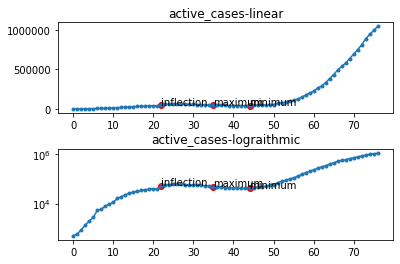

In [26]:
worldwide = df[df['Country/Region']=='worldwide']
ShowData(worldwide,'active_cases','smooth_active_first_derivative','smooth_active_second_derivative',10,1000,tit='')

In [27]:
df[df['Country/Region']=='Norway']

,Province/State,Country/Region,confirmed_cases,confirmed_first_derivative,confirmed_second_derivative,dead_cases,dead_first_derivative,dead_second_derivative,recovered_cases,recovered_first_derivative,...,test_positivity,Hospital_beds(Nationwide),Hospital_beds_density(Nationwide),confirmed_cases_per_beds,active_cases_per_beds,mortality_rate,population,confirmed_cases_per_million_people,active_cases_per_million_people,dead_cases_per_million_people
175,NaN,Norway,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,5.343471,16885.0,3.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5314336.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
CList = df['Country/Region']
CListU = df['Country/Region'].unique()
for c in CListU:
    ind = CList==c
    num = ind.sum()
    if num>1:
        df = AddWholeCountry(df, c)

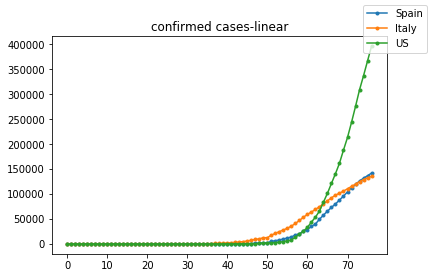

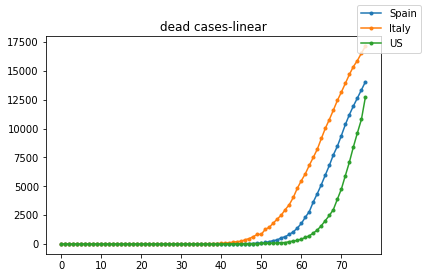

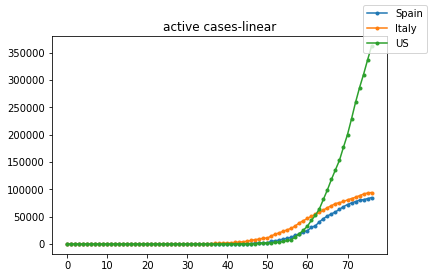

In [29]:
#countries
CList = ['Spain','Italy','US']
PlotCountries(df,CList,'confirmed_cases',isLog=False,tit='confirmed cases',d1key='',d2key='',d1tol=np.inf,d2tol=np.inf,isplot1d=False,isplot2d=False)
PlotCountries(df,CList,'dead_cases',isLog=False,tit='dead cases',d1key='',d2key='',d1tol=np.inf,d2tol=np.inf,isplot1d=False,isplot2d=False)
PlotCountries(df,CList,'active_cases',isLog=False,tit='active cases',d1key='',d2key='',d1tol=np.inf,d2tol=np.inf,isplot1d=False,isplot2d=False)

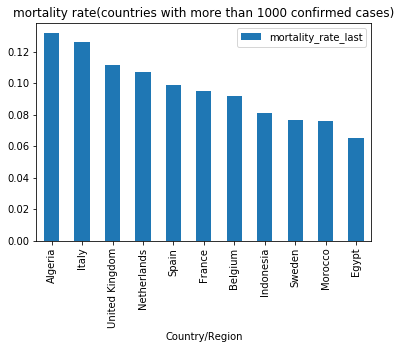

In [30]:
MinConfirmed = 1000
LastConfirmed = np.stack(df['confirmed_cases'].to_numpy())[:,-1]
ind = LastConfirmed > MinConfirmed
mortality_df = df[ind]
TopBarPlot(mortality_df,'mortality_rate',TopNum=10,CountryList=None,tit='mortality rate(countries with more than ' + str(MinConfirmed) + ' confirmed cases)')

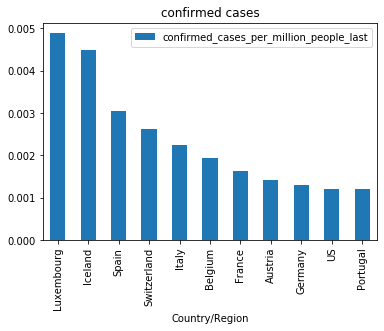

In [31]:
TopBarPlot(mortality_df,'confirmed_cases_per_million_people',TopNum=10,CountryList=None,tit='confirmed cases')

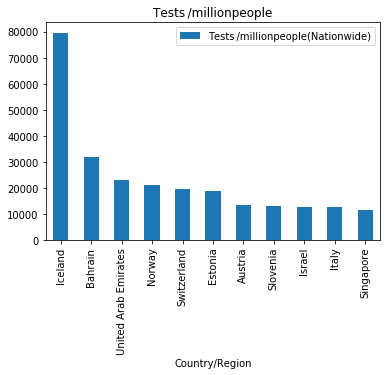

In [32]:
TopBarPlot(df,'Tests /millionpeople(Nationwide)',TopNum=10,CountryList=None,tit='Tests /millionpeople')

In [33]:
df.tail()

,Province/State,Country/Region,confirmed_cases,confirmed_first_derivative,confirmed_second_derivative,dead_cases,dead_first_derivative,dead_second_derivative,recovered_cases,recovered_first_derivative,...,test_positivity,Hospital_beds(Nationwide),Hospital_beds_density(Nationwide),confirmed_cases_per_beds,active_cases_per_beds,mortality_rate,population,confirmed_cases_per_million_people,active_cases_per_million_people,dead_cases_per_million_people
259,Saint Pierre and Miquelon,France,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.000446,206619.0,3.09,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6.698724e+07,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
260,NaN,South Sudan,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.000000,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.097592e+07,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
261,NaN,Western Sahara,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.000000,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
262,NaN,Sao Tome and Principe,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.000000,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.110280e+05,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
263,worldwide,worldwide,"[555, 654, 941, 1434, 2118, 2927, 5578, 6166, ...","[193.0, 390.0, 588.5, 746.5, 1730.0, 1619.5, 1...","[188, 206, 191, 125, 1842, -2063, 1480, -375, ...","[17, 18, 26, 42, 56, 82, 131, 133, 171, 213, 2...","[4.5, 12.0, 15.0, 20.0, 37.5, 25.5, 20.0, 40.0...","[7, 8, -2, 12, 23, -47, 36, 4, 4, 57, -39, 2, ...","[28, 30, 36, 39, 52, 61, 107, 126, 143, 222, 2...","[4.0,

In [41]:
def DataForModel(df,NDays,yKey,XkeyList=[]):#,MinConfirmedNum=1000,MinDays=15):
    #We will only look at queries with more than a certain nummber of confirmed cases
#     ind = np.stack(df['confirmed_cases'].to_numpy()).any()>MinConfirmedNum
#     print(ind)
#     filtered_df = df[ind]
    #we will only look at nationwide level
    filtered_df = df[(df['Province/State']=='all') | (df['Province/State'].isna())]
    #Now, let's filter the rows in which we have a minimal number of days with significant confirmed cases
    filtered_df = filtered_df[filtered_df['start_index'].notna()]
    for _, row in filtered_df.iterrows():
        #print(row['Country/Region'])
        l = NDays-row['start_index'] + 1
        l = int(l)
        time = np.arange(l)
        time = time.reshape(-1,1)
        AddVal = True
        for k in XkeyList:
            KeyVal = row[k]#np.stack(row[k].to_numpy())
            if np.isnan(KeyVal):
                AddVal = False
                break
            KeyVal = np.tile(KeyVal,l)
            KeyVal = KeyVal.reshape(-1,1)
            time = np.concatenate((time,KeyVal),axis=1)
        if not AddVal:
            continue
        it = np.array(row[yKey])[int(row['start_index']):]
        if np.isnan(it).any():
            continue
        if 'x' in locals():
            x = np.concatenate((x, time), axis=0)
        else:
            x = time 
        if 'y' in locals():
            y = np.concatenate((y,it))
        else:
            y = it
    #y = y[:,NDays-MinDays:NDays]
    return x,y

In [64]:
yKey = 'mortality_rate'#'confirmed_cases_per_million_people'
DataKeyList = ['Hospital_beds_density(Nationwide)','test_positivity','Tests /millionpeople(Nationwide)']#['Hospital_beds_density(Nationwide)','test_positivity','Tests /millionpeople(Nationwide)'],'population']
#x,y = DataForModel(df,NDays,'confirmed_cases_per_million_people',XkeyList=DataKeyList)#,MinConfirmedNum=1000),MinDays=NDays)
current_df = df[~np.isnan(df['start_index'])]
x,y = DataForModel(current_df,NDays,yKey,XkeyList=DataKeyList)#,MinConfirmedNum=1000),MinDays=NDays)

(28, 4)
(39, 4)
(30, 4)
(16, 4)


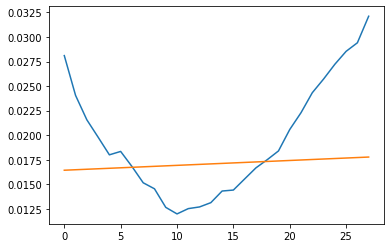

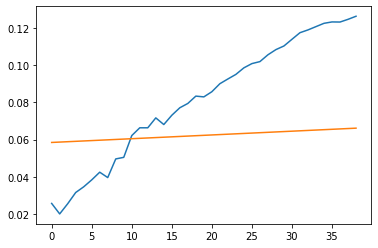

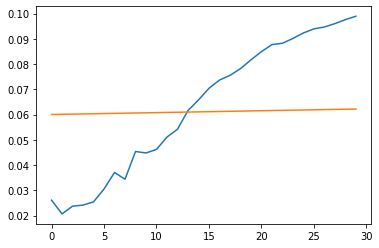

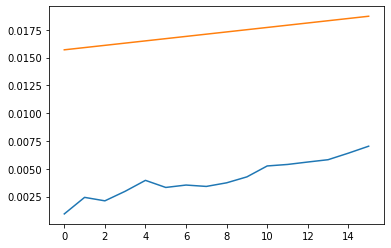

In [66]:
isLog=0
def predict_for_country(model,df,keys,country,NDays,StartDay=0,isLog=1):
    df = df[df['Country/Region']==country]
    df = df[(df['Province/State']=='all') | (df['Province/State'].isna())]
    X_pred = np.arange(StartDay, NDays).reshape(-1, 1)
    l = X_pred.shape[0]
    for k in keys:
        KeyVal = df[k].values#np.stack(row[k].to_numpy())
        if np.isnan(KeyVal):
            return
        KeyVal = np.tile(KeyVal,l)
        KeyVal = KeyVal.reshape(-1,1)
        X_pred = np.concatenate((X_pred,KeyVal),axis=1)
    if isLog:
        y_pred_log = model.predict(X_pred)
        y_pred = np.exp(y_pred_log)
    else:
        y_pred = model.predict(X_pred)
    return X_pred, y_pred
model = make_pipeline(PolynomialFeatures((3)), HuberRegressor())
if isLog:
    model.fit(x, np.log(y))
else:
    model.fit(x, y)
CList = ['US','Italy','Spain','Israel']#,'China',]
for country in CList:
    plt.figure()
    s = df[df['Country/Region']==country]['start_index'].to_numpy()
    v = np.stack(df[df['Country/Region']==country][yKey].to_numpy()).ravel()
    plt.plot(v[int(s[0]):])
    l = v.shape[0] - s[0]
    x_pred, y_pred = predict_for_country(model,df,DataKeyList,country,l)
    #x_pred, y_pred = predict_for_country(model,df,[],country,120)
    print(x_pred.shape)
    #plt.plot(x_pred[:,0],y_pred)
    coef = df[df['Country/Region']==country]['population']
    plt.plot(x_pred[:,0],y_pred-1)#coef.values*y_pred)
    #plt.plot()